In [1]:
import timeit

from numba import njit
import torch
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

# 1. Vectorization


### 1.1 Sum of array elements


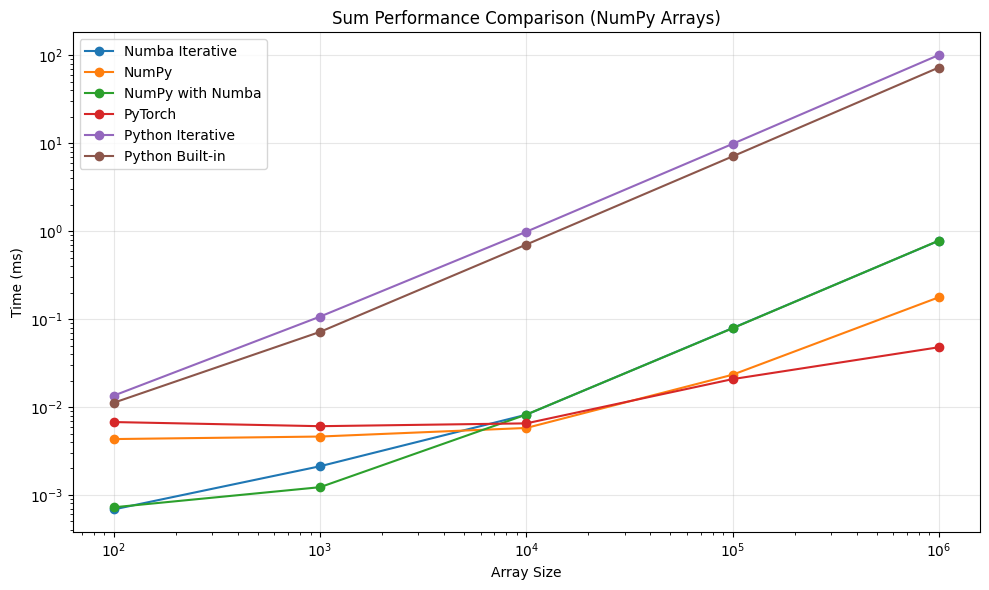

In [2]:
@njit
def sum_numba(x):
    total = 0.0
    for i in range(x.shape[0]):
        total += x[i]
    return total


def sum_numpy(x):
    return np.sum(x)


@njit
def sum_numpy_numba(x):
    return np.sum(x)


def sum_torch(x):
    x_torch = torch.from_numpy(x)
    return torch.sum(x_torch).item()


def sum_iterative(x):
    total = 0.0
    for value in x:
        total += value
    return total


def sum_builtin(x):
    return sum(x)


sum_functions = {
    "Numba Iterative": sum_numba,
    "NumPy": sum_numpy,
    "NumPy with Numba": sum_numpy_numba,
    "PyTorch": sum_torch,
    "Python Iterative": sum_iterative,
    "Python Built-in": sum_builtin,
}


def benchmark(sizes, runs=10):
    all_results = {}
    for n in sizes:
        a = np.random.rand(n).astype(np.float32)
        results = {}
        for name, func in sum_functions.items():
            func(a)  # warmup
            duration = timeit.timeit(lambda: func(a), number=runs)
            results[name] = duration / runs
        all_results[n] = results

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    for name in sum_functions.keys():
        times = [all_results[n][name] * 1000 for n in sizes]  # Convert to ms
        ax.plot(sizes, times, marker="o", label=name)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Array Size")
    ax.set_ylabel("Time (ms)")
    ax.set_title("Sum Performance Comparison (NumPy Arrays)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


benchmark([100, 1000, 10_000, 100_000, 1_000_000], runs=10)

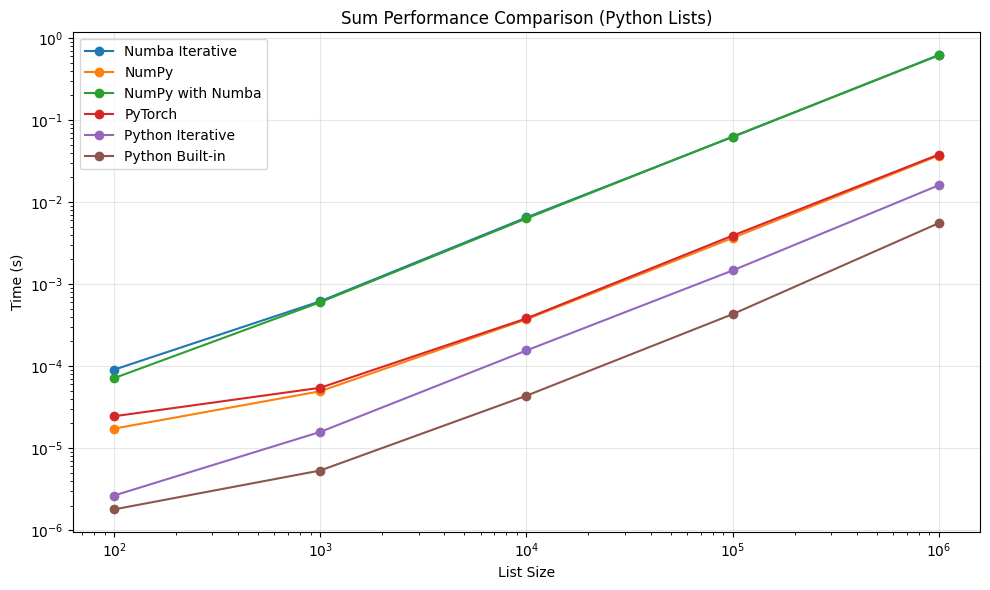

In [3]:
@njit
def sum_numba(x: list[float]):
    total = 0.0
    for i in range(len(x)):
        total += x[i]
    return total


def sum_numpy(x: list[float]):
    return np.sum(np.array(x))


@njit
def sum_numpy_numba(x: list[float]):
    return np.sum(np.array(x))


def sum_torch(x: list[float]):
    x_torch = torch.from_numpy(np.array(x))
    return torch.sum(x_torch).item()


def sum_iterative(x: list[float]):
    total = 0.0
    for value in x:
        total += value
    return total


def sum_builtin(x: list[float]):
    return sum(x)


sum_functions = {
    "Numba Iterative": sum_numba,
    "NumPy": sum_numpy,
    "NumPy with Numba": sum_numpy_numba,
    "PyTorch": sum_torch,
    "Python Iterative": sum_iterative,
    "Python Built-in": sum_builtin,
}


def benchmark(sizes, runs=1):
    all_results = {}
    for n in sizes:
        a = np.random.rand(n).astype(np.float32).tolist()
        results = {}
        for name, func in sum_functions.items():
            func(a)  # warmup
            duration = timeit.timeit(lambda: func(a), number=runs)
            results[name] = duration / runs
        all_results[n] = results

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    for name in sum_functions.keys():
        times = [all_results[n][name] for n in sizes]  # in seconds
        ax.plot(sizes, times, marker="o", label=name)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("List Size")
    ax.set_ylabel("Time (s)")
    ax.set_title("Sum Performance Comparison (Python Lists)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


benchmark([100, 1000, 10_000, 100_000, 1_000_000], runs=1)

### 1.2 Sum of rows vs columns


#### PyTorch

Usually summing over rows (dim=1) is faster than summing over columns (dim=0) due to memory layout (row-major order).


In [9]:
def benchmark_torch(rows=1000, cols=1000, runs=10, device="cpu"):
    device = torch.device(device)
    tensor = torch.randn(rows, cols, device=device)
    print(f"Benchmarking sum over array of shape: {rows}x{cols}")
    print(f"Device: {device}")

    t_rows = timeit.timeit(lambda: torch.sum(tensor, dim=1), number=runs)
    print(f"Sum Rows: {t_rows / runs:.6f} seconds per run")

    t_cols = timeit.timeit(lambda: torch.sum(tensor, dim=0), number=runs)
    print(f"Sum Columns: {t_cols / runs:.6f} seconds per run")

    print(f"Rows faster by: {t_cols / t_rows:.2f}x\n")


runs = 50
benchmark_torch(25_000, 25_000, runs=runs)
benchmark_torch(10_000, 10_000, runs=runs)
benchmark_torch(1_000, 1_000, runs=runs)
benchmark_torch(100, 100, runs=runs)
benchmark_torch(100_000, 100, runs=runs)
benchmark_torch(100, 100_000, runs=runs)

Benchmarking sum over array of shape: 25000x25000
Device: cpu
Sum Rows: 0.067361 seconds per run
Sum Columns: 0.241570 seconds per run
Rows faster by: 3.59x

Benchmarking sum over array of shape: 10000x10000
Device: cpu
Sum Rows: 0.010810 seconds per run
Sum Columns: 0.022712 seconds per run
Rows faster by: 2.10x

Benchmarking sum over array of shape: 1000x1000
Device: cpu
Sum Rows: 0.000033 seconds per run
Sum Columns: 0.000035 seconds per run
Rows faster by: 1.07x

Benchmarking sum over array of shape: 100x100
Device: cpu
Sum Rows: 0.000005 seconds per run
Sum Columns: 0.000005 seconds per run
Rows faster by: 1.06x

Benchmarking sum over array of shape: 100000x100
Device: cpu
Sum Rows: 0.002427 seconds per run
Sum Columns: 0.003427 seconds per run
Rows faster by: 1.41x

Benchmarking sum over array of shape: 100x100000
Device: cpu
Sum Rows: 0.001102 seconds per run
Sum Columns: 0.002024 seconds per run
Rows faster by: 1.84x



#### Numpy

Interestingly in Numpy it doesn't work that way.


In [6]:
def benchmark_np(rows=1000, cols=1000, runs=10):
    a = np.random.rand(rows, cols).astype(np.float32)
    print(f"Benchmarking sum over array of shape ({rows}, {cols})")

    t_rows = timeit.timeit(lambda: np.sum(a, axis=1), number=runs)
    print(f"Sum Rows: {t_rows / runs:.6f} seconds per run")

    t_cols = timeit.timeit(lambda: np.sum(a, axis=0), number=runs)
    print(f"Sum Columns: {t_cols / runs:.6f} seconds per run")

    print(f"Rows faster by: {t_cols / t_rows:.2f}x\n")


runs = 50
benchmark_np(25_000, 25_000, runs=runs)
benchmark_np(10_000, 10_000, runs=runs)
benchmark_np(1_000, 1_000, runs=runs)
benchmark_np(100, 100, runs=runs)
benchmark_np(100_000, 100, runs=runs)
benchmark_np(100, 100_000, runs=runs)

Benchmarking sum over array of shape (25000, 25000)
Sum Rows: 0.157623 seconds per run
Sum Columns: 0.159318 seconds per run
Rows faster by: 1.01x

Benchmarking sum over array of shape (10000, 10000)
Sum Rows: 0.026545 seconds per run
Sum Columns: 0.024680 seconds per run
Rows faster by: 0.93x

Benchmarking sum over array of shape (1000, 1000)
Sum Rows: 0.000205 seconds per run
Sum Columns: 0.000167 seconds per run
Rows faster by: 0.81x

Benchmarking sum over array of shape (100, 100)
Sum Rows: 0.000007 seconds per run
Sum Columns: 0.000007 seconds per run
Rows faster by: 1.00x

Benchmarking sum over array of shape (100000, 100)
Sum Rows: 0.004362 seconds per run
Sum Columns: 0.004236 seconds per run
Rows faster by: 0.97x

Benchmarking sum over array of shape (100, 100000)
Sum Rows: 0.002583 seconds per run
Sum Columns: 0.002621 seconds per run
Rows faster by: 1.01x



#### PyTorch (GPU)

In [examples/sum_rows_vs_cols.py](examples/sum_rows_vs_cols.py) we can see that on GPU the performance difference is even more pronounced, with summing over rows being significantly faster than summing over columns.


### 1.3 Vectorization in practice - Evolutionary Algorithms


In [ ]:
def evaluate_population_naive(population, target):
    """Evaluate fitness for each individual using loops."""
    fitness = []
    for individual in population:
        error = sum((individual[i] - target[i]) ** 2 for i in range(len(target)))
        fitness.append(1.0 / (1.0 + error))
    return fitness


def evaluate_population_vectorized(population, target):
    """Evaluate fitness for entire population at once using NumPy."""
    errors = np.sum((population - target) ** 2, axis=1)
    return 1.0 / (1.0 + errors)


pop_size = 10_000
genome_length = 100
population_list = [np.random.rand(genome_length).tolist() for _ in range(pop_size)]
population_array = np.random.rand(pop_size, genome_length)
target = np.random.rand(genome_length)

runs = 10

# Warmup
evaluate_population_naive(population_list, target.tolist())
evaluate_population_vectorized(population_array, target)

# Benchmark both approaches
t_naive = timeit.timeit(lambda: evaluate_population_naive(population_list, target.tolist()), number=runs) / runs
t_vectorized = timeit.timeit(lambda: evaluate_population_vectorized(population_array, target), number=runs) / runs

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
methods = ["Naive\n(loops)", "Vectorized\n(NumPy)"]
times = [t_naive * 1000, t_vectorized * 1000]  # Convert to ms
colors = ["#ff7f0e", "#2ca02c"]

bars = ax.bar(methods, times, color=colors, alpha=0.8)
ax.set_ylabel("Time (ms)")
ax.set_title(f"Evolutionary Algorithm Fitness Evaluation\n(Population: {pop_size:,}, Genome: {genome_length})")
ax.grid(True, alpha=0.3, axis="y")

# Add speedup annotation
speedup = t_naive / t_vectorized
ax.text(0.5, max(times) * 0.8, f"{speedup:.1f}× faster", ha="center", fontsize=14, fontweight="bold", color="green")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f} ms", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Naive (loops): 0.114848 seconds per run
Vectorized (NumPy): 0.003016 seconds per run
Vectorized faster by: 38.07x


# 2. Kernel Fusion


Kernel is a function that runs on the GPU.

Often the kernel is memory bound, meaning that the performance is limited by memory bandwidth rather than compute. That means that the kernel spends most of its time waiting for data to be loaded from memory, rather than performing computations. By fusing multiple operations into a single kernel, we can reduce the number of memory accesses, reduce overhead, and improve performance.

We use GELU activation function as an example, which is defined as:
$$\text{GELU}(x) = x \cdot \frac{1}{2} \left(1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right)$$

where $\text{erf}$ is the [error function](https://en.wikipedia.org/wiki/Error_function). This function is commonly used in deep learning models, and it can be implemented in a straightforward way using PyTorch. However, we can also fuse the operations into a single kernel using `torch.compile` to achieve better performance.

Resources:

- [PyTorch documentation on kernel fusion](https://pytorch.org/docs/stable/generated/torch.compile.html#torch.compile)
- [Kernel fusion in CUDA](https://www.vrushankdes.ai/diffusion-policy-inference-optimization/part-vi---kernel-fusion-in-cuda)

torch.compile is the new way to speed up your PyTorch code! torch.compile makes PyTorch code run faster by JIT-compiling PyTorch code into optimized kernels, while requiring minimal code changes.

torch.compile accomplishes this by tracing through your Python code, looking for PyTorch operations. Code that is difficult to trace will result a graph break, which are lost optimization opportunities, rather than errors or silent incorrectness.


In [ ]:
@torch.compile
def gelu_fuse(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))


def gelu_slow(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))


x = torch.randn(10_000_000)
# Warmup, torch.compile takes longer in the first iteration, as it must compile the model,
# but in subsequent iterations, we see significant speedups compared to eager.

gelu_fuse(x)
gelu_slow(x)

runs = 10
t_gelu = timeit.timeit(lambda: gelu_fuse(x), number=runs) / runs
t_gelu_slow = timeit.timeit(lambda: gelu_slow(x), number=runs) / runs

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
methods = ["Eager Mode", "Compiled\n(torch.compile)"]
times = [t_gelu_slow * 1000, t_gelu * 1000]  # Convert to ms
colors = ["#ff7f0e", "#2ca02c"]

bars = ax.bar(methods, times, color=colors, alpha=0.8)
ax.set_ylabel("Time (ms)")
ax.set_title("GELU Activation: Kernel Fusion Performance")
ax.grid(True, alpha=0.3, axis="y")

# Add speedup annotation
speedup = t_gelu_slow / t_gelu
ax.text(0.5, max(times) * 0.8, f"{speedup:.2f}× faster", ha="center", fontsize=14, fontweight="bold", color="green")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f} ms", ha="center", va="bottom")

plt.tight_layout()
plt.show()

PyTorch, by design, runs in eager mode. What is eager mode?
It means that torch executes operations immediately, without building a static computation graph ahead of time. Since torch doesn’t know in advance how much memory or what computation graph will be needed, it tends to over allocate memory to avoid data loss, prioritizing compatibility over optimization.

When you enable Torch Compile, there is a kind of “simulation run” that captures the computation graph and selects optimal execution parameters. This is the "compile" step.
You may see messages like Triton AOT or Torch AOT, where AOT stands for Ahead of Time.


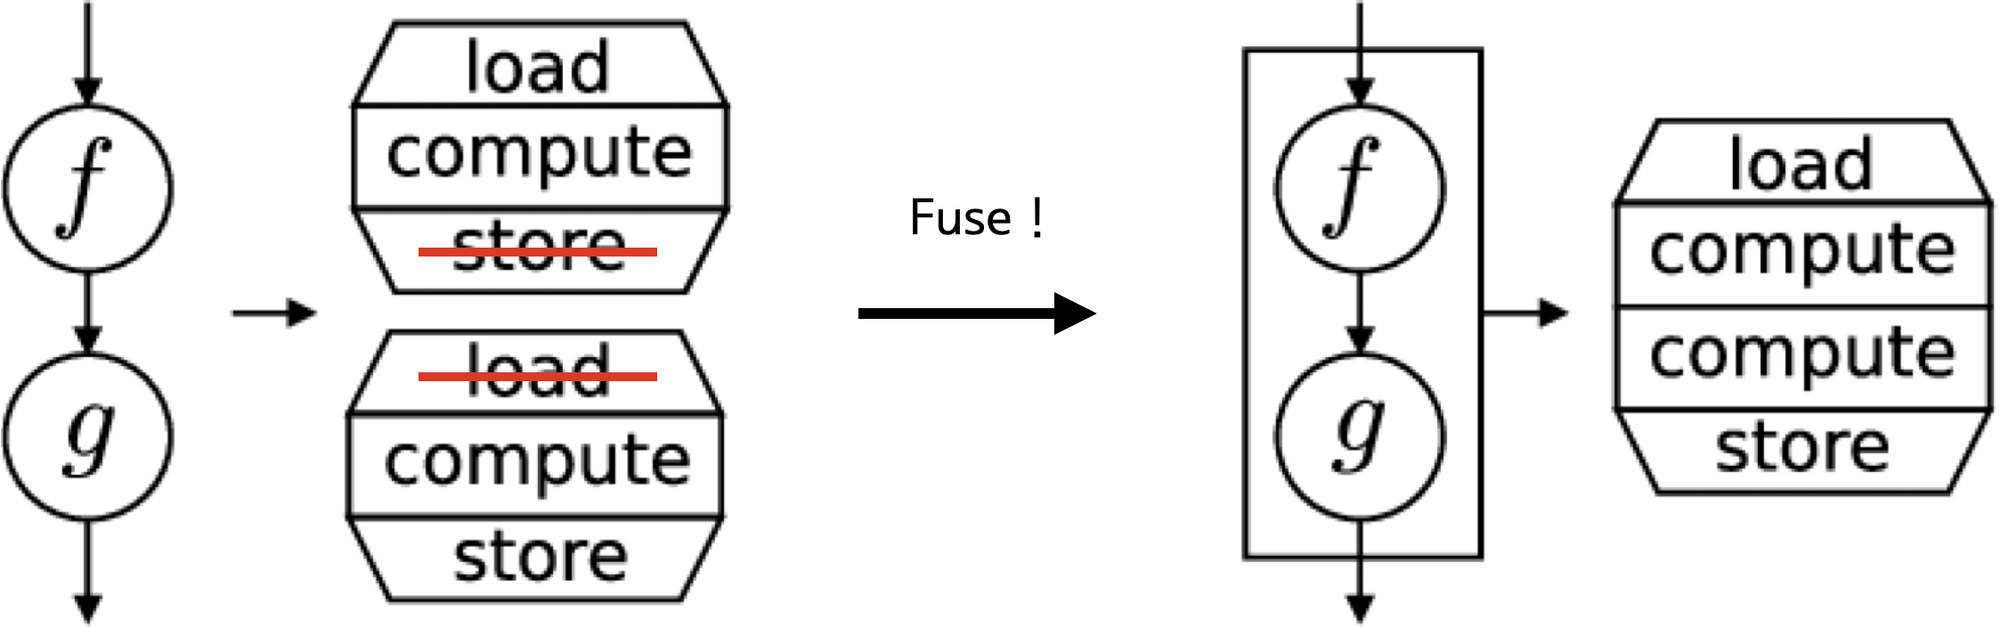


https://ar5iv.labs.arxiv.org/html/1305.1183


# 3. Weird optimizations


In [ ]:
def foo(n: int):
    for i in range(n):
        str(i)


def bar(n: int):
    s = str  # local variable lookup is faster than global lookup
    for i in range(n):
        s(i)


runs = 5
t_global = timeit.timeit(lambda: foo(10_000_000), number=runs) / runs
t_local = timeit.timeit(lambda: bar(10_000_000), number=runs) / runs

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
methods = ["Global Lookup\n(foo)", "Local Lookup\n(bar)"]
times = [t_global * 1000, t_local * 1000]  # Convert to ms
colors = ["#ff7f0e", "#2ca02c"]

bars = ax.bar(methods, times, color=colors, alpha=0.8)
ax.set_ylabel("Time (ms)")
ax.set_title("Global vs Local Variable Lookup Performance")
ax.grid(True, alpha=0.3, axis="y")

# Add speedup annotation
speedup = t_global / t_local
ax.text(0.5, max(times) * 0.8, f"{speedup:.2f}× faster", ha="center", fontsize=14, fontweight="bold", color="green")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.0f} ms", ha="center", va="bottom")

plt.tight_layout()
plt.show()

foo: 0.841120 seconds per run
bar: 0.811540 seconds per run
bar faster by: 1.04x



# 4. Pandas vs Polars


The biggest improvement over Pandas is that Polars has an actual query optimizer, which of course requires that you have a lazy evaluation model.

**Resources**:

- https://pipeline2insights.substack.com/p/pandas-vs-polars-vs-duckdb-vs-pyspark-benchmarking-real-experiments
- https://docs.pola.rs/user-guide/migration/pandas/


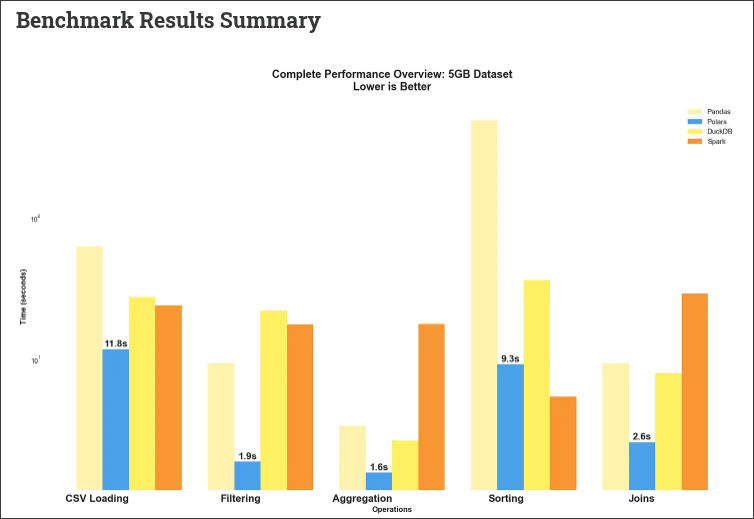


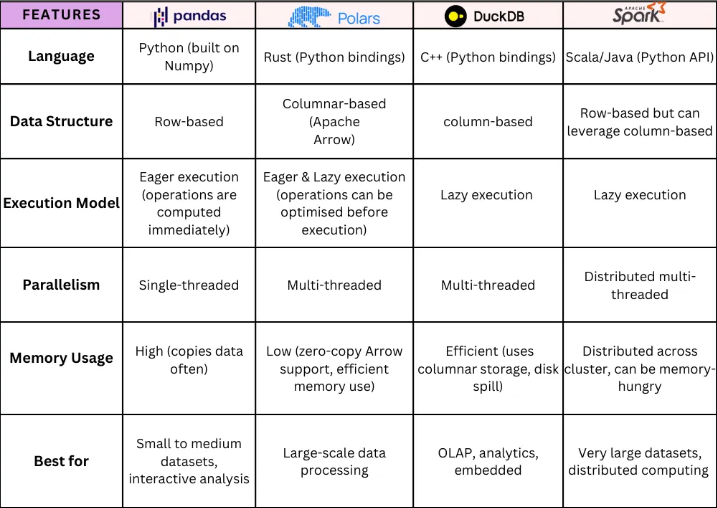


In [ ]:
# Prepare data
rows = 1_000_000
runs = 10

df_pandas = pd.DataFrame({"group": np.random.choice(["A", "B", "C", "D"], size=rows), "value": np.random.rand(rows)})
df_polars = pl.from_pandas(df_pandas)

# Benchmark both
t_pandas = timeit.timeit(lambda: df_pandas.groupby("group")["value"].sum(), number=runs) / runs
t_polars = timeit.timeit(lambda: df_polars.group_by("group").agg(pl.col("value").sum()), number=runs) / runs

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
libraries = ["Pandas", "Polars"]
times = [t_pandas * 1000, t_polars * 1000]  # Convert to ms
colors = ["#1f77b4", "#ff7f0e"]

bars = ax.bar(libraries, times, color=colors, alpha=0.8)
ax.set_ylabel("Time (ms)")
ax.set_title(f"GroupBy Performance Comparison ({rows:,} rows)")
ax.grid(True, alpha=0.3, axis="y")

# Add speedup annotation
speedup = t_pandas / t_polars
ax.text(0.5, max(times) * 0.8, f"{speedup:.1f}× faster", ha="center", fontsize=14, fontweight="bold", color="green")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f} ms", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Benchmarking groupby with 1000000 rows
Pandas groupby: 0.028954 seconds per run
Polars groupby: 0.006354 seconds per run
Polars faster by: 4.56x

